# Classify MNIST Dataset

Data Source: 
https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

In [15]:
# hide unnecessary alert messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# 1. Introduction

The “hello world” of object recognition for machine learning and deep learning is the MNIST dataset for handwritten digit recognition.

In this post you will discover how to develop a deep learning model to achieve near state of the art performance on the MNIST handwritten digit recognition task in Python using the Keras deep learning library.

After completing this tutorial, you will know:

    How to load the MNIST dataset in Keras.
    How to develop and evaluate a baseline neural network model for the MNIST problem.
    How to implement and evaluate a simple Convolutional Neural Network for MNIST.
    How to implement a close to state-of-the-art deep learning model for MNIST.


### Description of the MNIST Handwritten Digit Recognition Problem

The MNIST problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem.

The dataset was constructed from a number of scanned document dataset available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.

Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required.

Each image is a 28 by 28 pixel square (784 pixels total). A standard split of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.

It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. Results are reported using prediction error, which is nothing more than the inverted classification accuracy.

Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks. There is a listing of the state-of-the-art results and links to the relevant papers on the MNIST and other datasets on Rodrigo Benenson’s webpage.

### Installs & Imports

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dropout

# numpy -> linear algebra & matrix operations
import matplotlib.pyplot as plt

### Visualize the dataset

The Keras deep learning library provides a convenience method for loading the MNIST dataset.

The dataset is downloaded automatically the first time this function is called and is stored in your home directory in ~/.keras/datasets/mnist.pkl.gz as a 15MB file.

This is very handy for developing and testing deep learning models.

To demonstrate how easy it is to load the MNIST dataset, we will first write a little script to download and visualize the first 4 images in the training dataset.

In [2]:
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Running the example loads the MNIST train and test dataset and prints their shape.

We can see that there are 60,000 examples in the training dataset and 10,000 in the test dataset and that images are indeed square with 28×28 pixels.

In [3]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


A plot of the first few images in the dataset is also created showing the natural handwritten nature of the images to be classified.
Plot of a Subset of Images From the MNIST Dataset

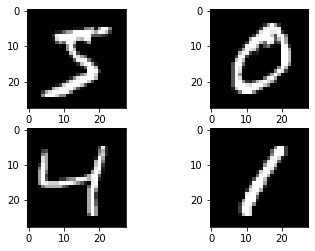

In [4]:
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

# 2. Baseline model (Feed-Forward MLP)

Do we really need a complex model like a convolutional neural network to get the best results with MNIST?

You can get very good results using a very simple neural network model with a single hidden layer. In this section we will create a simple multi-layer perceptron model that achieves an error rate of 1.74%. We will use this as a baseline for comparing more complex convolutional neural network models.

Let’s start off by importing the classes and functions we will need.

In [5]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

Now we can load the MNIST dataset using the Keras helper function.

In [6]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

The training dataset is structured as a 3-dimensional array of instance, image width and image height. For a multi-layer perceptron model we must reduce the images down into a vector of pixels. In this case the 28×28 sized images will be 784 pixel input values.

We can do this transform easily using the reshape() function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [ ]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [ ]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
print(round(X_train.max(),5))
print(round(X_test.max(),5))

1.0
1.0


Finally, the output variable is an integer from 0 to 9. This is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [ ]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
num_classes

10

We are now ready to create our simple neural network model. We will define our model in a function. This is handy if you want to extend the example later and try and get a better score.

In [12]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, 
                    input_dim=num_pixels, 
                    kernel_initializer='normal', 
                    activation='relu'))
	model.add(Dense(num_classes, 
                    kernel_initializer='normal', 
                    activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
	return model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.



In [16]:
# build the model
model = baseline_model()

We can now fit and evaluate the model. The model is fit over 10 epochs with updates every 200 images. The test data is used as the validation dataset, allowing you to see the skill of the model as it trains. A verbose value of 2 is used to reduce the output to one line for each training epoch.


Running the example might take a few minutes when run on a CPU.



In [17]:
# Fit the model
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=200, 
          verbose=2)

Epoch 1/10
300/300 - 3s - loss: 0.2799 - accuracy: 0.9206 - val_loss: 0.1428 - val_accuracy: 0.9587 - 3s/epoch - 9ms/step
Epoch 2/10
300/300 - 2s - loss: 0.1100 - accuracy: 0.9687 - val_loss: 0.1005 - val_accuracy: 0.9711 - 2s/epoch - 6ms/step
Epoch 3/10
300/300 - 2s - loss: 0.0720 - accuracy: 0.9790 - val_loss: 0.0846 - val_accuracy: 0.9735 - 2s/epoch - 6ms/step
Epoch 4/10
300/300 - 2s - loss: 0.0500 - accuracy: 0.9851 - val_loss: 0.0674 - val_accuracy: 0.9782 - 2s/epoch - 6ms/step
Epoch 5/10
300/300 - 2s - loss: 0.0362 - accuracy: 0.9898 - val_loss: 0.0645 - val_accuracy: 0.9786 - 2s/epoch - 6ms/step
Epoch 6/10
300/300 - 2s - loss: 0.0261 - accuracy: 0.9931 - val_loss: 0.0617 - val_accuracy: 0.9801 - 2s/epoch - 6ms/step
Epoch 7/10
300/300 - 2s - loss: 0.0186 - accuracy: 0.9955 - val_loss: 0.0599 - val_accuracy: 0.9799 - 2s/epoch - 6ms/step
Epoch 8/10
300/300 - 2s - loss: 0.0145 - accuracy: 0.9967 - val_loss: 0.0665 - val_accuracy: 0.9796 - 2s/epoch - 6ms/step
Epoch 9/10
300/300 - 2s 

Finally, the test dataset is used to evaluate the model and a classification error rate is printed.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

You should see the output below. This very simple network defined in very few lines of code achieves a respectable error rate of 1.71%.

In [18]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Accuracy: %.2f%%" % (scores[1]*100))
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Accuracy: 98.06%
Baseline Error: 1.94%


# 4. Simple Convolutional Neural Network

![](https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

Additional reading:
* https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/
* https://machinelearningmastery.com/understanding-the-design-of-a-convolutional-neural-network/

Now that we have seen how to load the MNIST dataset and train a simple multi-layer perceptron model on it, it is time to develop a more sophisticated convolutional neural network or CNN model.

Keras does provide a lot of capability for creating convolutional neural networks.

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers, Pooling layers and Dropout layers.

The first step is to import the classes and functions needed.

In [19]:
# Imports
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

## Model Building

Next we need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height][channels].

Note, we are forcing so-called channels-last ordering for consistency in this example.

In the case of RGB, the last dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [20]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

As before, it is a good idea to normalize the pixel values to the range 0 and 1 and one hot encode the output variables.

In [21]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Next we define our neural network model.

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

- The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
- Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
- The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
- Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
- Next a fully connected layer with 128 neurons and rectifier activation function.
- Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

In [22]:
# define a simple CNN model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

We evaluate the model the same way as before with the multi-layer perceptron. The CNN is fit over 10 epochs with a batch size of 200.

In [23]:
# build the model
model = baseline_model()

Running the example, the accuracy on the training and validation test is printed each epoch and at the end of the classification error rate is printed.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

Epochs may take about 45 seconds to run on the GPU (e.g. on AWS). 

In [24]:
# Fit the model
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=10, 
          batch_size=200)

Epoch 1/10
300/300 [==============================] - 14s 47ms/step - loss: 0.2525 - accuracy: 0.9265 - val_loss: 0.0826 - val_accuracy: 0.9742
Epoch 2/10
300/300 [==============================] - 13s 45ms/step - loss: 0.0762 - accuracy: 0.9776 - val_loss: 0.0566 - val_accuracy: 0.9824
Epoch 3/10
300/300 [==============================] - 13s 45ms/step - loss: 0.0532 - accuracy: 0.9837 - val_loss: 0.0467 - val_accuracy: 0.9836
Epoch 4/10
300/300 [==============================] - 13s 45ms/step - loss: 0.0417 - accuracy: 0.9873 - val_loss: 0.0358 - val_accuracy: 0.9885
Epoch 5/10
300/300 [==============================] - 13s 45ms/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.0411 - val_accuracy: 0.9861
Epoch 6/10
300/300 [==============================] - 14s 45ms/step - loss: 0.0285 - accuracy: 0.9910 - val_loss: 0.0334 - val_accuracy: 0.9889
Epoch 7/10
300/300 [==============================] - 13s 45ms/step - loss: 0.0235 - accuracy: 0.9927 - val_loss: 0.0363 - val_accuracy:

## Evaluate the model

You can see that the network achieves an error rate of 0.95%, which is better than our simple multi-layer perceptron model above.

In [25]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Accuracy: %.2f%%" % (scores[1]*100))
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Accuracy: 98.78%
CNN Error: 1.22%


# 4. More Complex CNN

Now that we have seen how to create a simple CNN, let’s take a look at a model capable of close to state of the art results.

We import classes and function then load and prepare the data the same as in the previous CNN example.

In [26]:
# Larger CNN for the MNIST Dataset
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

## Model Building

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

- Convolutional layer with 30 feature maps of size 5×5.
- Pooling layer taking the max over 2*2 patches.
- Convolutional layer with 15 feature maps of size 3×3.
- Pooling layer taking the max over 2*2 patches.
- Dropout layer with a probability of 20%.
- Flatten layer.
- Fully connected layer with 128 neurons and rectifier activation.
- Fully connected layer with 50 neurons and rectifier activation.
- Output layer.


In [27]:
# define the larger model
def larger_model():
	# create model
	model = Sequential()
	model.add(Conv2D(30, (5, 5), input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Conv2D(15, (3, 3), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

Like the previous two experiments, the model is fit over 10 epochs with a batch size of 200.

In [ ]:
# build the model
model = larger_model()

Running the example prints accuracy on the training and validation datasets each epoch and a final classification error rate.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

The model takes about 100 seconds to run per epoch.

In [28]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)

Epoch 1/10
300/300 [==============================] - 14s 46ms/step - loss: 0.0135 - accuracy: 0.9954 - val_loss: 0.0346 - val_accuracy: 0.9883
Epoch 2/10
300/300 [==============================] - 13s 45ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 3/10
300/300 [==============================] - 13s 44ms/step - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0365 - val_accuracy: 0.9893
Epoch 4/10
300/300 [==============================] - 14s 46ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.0341 - val_accuracy: 0.9897
Epoch 5/10
300/300 [==============================] - 13s 44ms/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0363 - val_accuracy: 0.9890
Epoch 6/10
300/300 [==============================] - 13s 44ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0364 - val_accuracy: 0.9894
Epoch 7/10
300/300 [==============================] - 13s 44ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0352 - val_accuracy:

## Evaluation of the CNN

This slightly larger model achieves the respectable classification error rate of 0.83%. This is not an optimized network topology. Nor is a reproduction of a network topology from a recent paper. There is a lot of opportunity for you to tune and improve upon this model.

What is the best error rate score you can achieve?

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Accuracy: %.2f%%" % (scores[1]*100))
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Save the model
model.save('models/cnn_model_3.h5')

## Make a new prediction

In [ ]:
# make a prediction for a new image.
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [ ]:
image_7='inputs/sample_image_7.png'
image_3='inputs/sample_image_3.png'
image_2='inputs/sample_image_2.png'

In [ ]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [ ]:
# load an image and predict the class
def run_example(filename):
	# load the image
	img = load_image(filename)
	# load model
	model = load_model('models/cnn_model_3.h5')
	# predict the class
	predict_value = model.predict(img)
	digit = argmax(predict_value)
	print(digit)

In [ ]:
# entry point, run the example
run_example(image_7)

In [ ]:
# entry point, run the example
run_example(image_3)

In [ ]:
# entry point, run the example
run_example(image_2)

# 5. In-depth Discussion

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

The MNIST handwritten digit classification problem is a standard dataset used in computer vision and deep learning.

Although the dataset is effectively solved, it can be used as the basis for learning and practicing how to develop, evaluate, and use convolutional deep learning neural networks for image classification from scratch. This includes how to develop a robust test harness for estimating the performance of the model, how to explore improvements to the model, and how to save the model and later load it to make predictions on new data.

In this tutorial, you will discover how to develop a convolutional neural network for handwritten digit classification from scratch.

After completing this tutorial, you will know:

    How to develop a test harness to develop a robust evaluation of a model and establish a baseline of performance for a classification task.
    How to explore extensions to a baseline model to improve learning and model capacity.
    How to develop a finalized model, evaluate the performance of the final model, and use it to make predictions on new images.

### Model Evaluation Methodology

Although the MNIST dataset is effectively solved, it can be a useful starting point for developing and practicing a methodology for solving image classification tasks using convolutional neural networks.

Instead of reviewing the literature on well-performing models on the dataset, we can develop a new model from scratch.

The dataset already has a well-defined train and test dataset that we can use.

In order to estimate the performance of a model for a given training run, we can further split the training set into a train and validation dataset. Performance on the train and validation dataset over each run can then be plotted to provide learning curves and insight into how well a model is learning the problem.

The Keras API supports this by specifying the “validation_data” argument to the model.fit() function when training the model, that will, in turn, return an object that describes model performance for the chosen loss and metrics on each training epoch.

In order to estimate the performance of a model on the problem in general, we can use k-fold cross-validation, perhaps five-fold cross-validation. This will give some account of the models variance with both respect to differences in the training and test datasets, and in terms of the stochastic nature of the learning algorithm. The performance of a model can be taken as the mean performance across k-folds, given the standard deviation, that could be used to estimate a confidence interval if desired.

We can use the KFold class from the scikit-learn API to implement the k-fold cross-validation evaluation of a given neural network model. There are many ways to achieve this, although we can choose a flexible approach where the KFold class is only used to specify the row indexes used for each spit.

We will hold back the actual test dataset and use it as an evaluation of our final model.

### Baseline Model
The first step is to develop a baseline model.

This is critical as it both involves developing the infrastructure for the test harness so that any model we design can be evaluated on the dataset, and it establishes a baseline in model performance on the problem, by which all improvements can be compared.

The design of the test harness is modular, and we can develop a separate function for each piece. This allows a given aspect of the test harness to be modified or inter-changed, if we desire, separately from the rest.

We can develop this test harness with five key elements. They are the loading of the dataset, the preparation of the dataset, the definition of the model, the evaluation of the model, and the presentation of results.

We know some things about the dataset.

For example, we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale.

Therefore, we can load the images and reshape the data arrays to have a single color channel.

We also know that there are 10 classes and that classes are represented as unique integers.

We can, therefore, use a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes. We can achieve this with the to_categorical() utility function.

In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

The load_dataset() function implements these behaviors and can be used to load the dataset.

In [ ]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

### Prepare Pixel Data

We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

The prep_pixels() function below implements these behaviors and is provided with the pixel values for both the train and test datasets that will need to be scaled.

This function must be called to prepare the pixel values prior to any modeling.

In [ ]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

### Define Model

Next, we need to define a baseline convolutional neural network model for the problem.

The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

The define_model() function below will define and return this model.

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

### Evaluate Model

After the model is defined, we need to evaluate it.

The model will be evaluated using five-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.

The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

The evaluate_model() function below implements these behaviors, taking the training dataset as arguments and returning a list of accuracy scores and training histories that can be later summarized.

In [ ]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=1)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

### Present Results

Once the model has been evaluated, we can present the results.

There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. These can be implemented using separate functions.

First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. The summarize_diagnostics() function below creates and shows this plot given the collected training histories.

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

Next, the classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

The summarize_performance() function below implements this for a given list of scores collected during model evaluation.


In [ ]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	plt.boxplot(scores)
	plt.show()

### Test harness

We need a function that will drive the test harness.

This involves calling all of the define functions.

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

We now have everything we need; the complete code example for a baseline convolutional neural network model on the MNIST dataset is listed below.

### Step 1

Running the example prints the classification accuracy for each fold of the cross-validation process. This is helpful to get an idea that the model evaluation is progressing.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

We can see two cases where the model achieves perfect skill and one case where it achieved lower than 98% accuracy. These are good results.

### Step 2

Next, a diagnostic plot is shown, giving insight into the learning behavior of the model across each fold.

In this case, we can see that the model generally achieves a good fit, with train and test learning curves converging. There is no obvious sign of over- or underfitting.

### Step 3

Next, a summary of the model performance is calculated.

We can see in this case, the model has an estimated skill of about 98.6%, which is reasonable.

### Step 4

Finally, a box and whisker plot is created to summarize the distribution of accuracy scores.

We now have a robust test harness and a well-performing baseline model.



In [ ]:
# entry point, run the test harness
run_test_harness()

How to Develop an Improved Model

There are many ways that we might explore improvements to the baseline model.

We will look at areas of model configuration that often result in an improvement, so-called low-hanging fruit. The first is a change to the learning algorithm, and the second is an increase in the depth of the model.
Improvement to Learning

There are many aspects of the learning algorithm that can be explored for improvement.

Perhaps the point of biggest leverage is the learning rate, such as evaluating the impact that smaller or larger values of the learning rate may have, as well as schedules that change the learning rate during training.

Another approach that can rapidly accelerate the learning of a model and can result in large performance improvements is batch normalization. We will evaluate the effect that batch normalization has on our baseline model.

Batch normalization can be used after convolutional and fully connected layers. It has the effect of changing the distribution of the output of the layer, specifically by standardizing the outputs. This has the effect of stabilizing and accelerating the learning process.

We can update the model definition to use batch normalization after the activation function for the convolutional and dense layers of our baseline model. 

In [ ]:
# Save the model
model.save('models/cnn_model_4.h5')